In [1]:
import nptdms as tdms
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import time

# collect all info of temperature file

In [33]:
dir_temp = "./temperature_round/" 
suffix = ".csv"

all_df = pd.DataFrame(columns = ["round","dur_second","T_min1","T_max","T_min2"])
for (_,_,files) in os.walk(dir_temp):
    for file in files:
        try:
            l = file[:-4].split("-")
            l = [i for i in l if i!=""]
            l = np.array([int(i) for i in l]).reshape(1,5)
            df = pd.DataFrame(l, columns = ["round","dur_second","T_min1","T_max","T_min2"])
            all_df = pd.concat([all_df,df],axis = 0)
        except:
            print(file)

all_df.to_csv("all_temp_info.csv",index = False)       
print(all_df.shape)
all_df.head()                      

(34925, 5)


,round,dur_second,T_min1,T_max,T_min2
0,1,10,19,41,35
0,10,30,76,126,80
0,100,33,103,170,98
0,1000,35,98,170,98
0,10000,28,88,170,88


# choose useful files

In [124]:
# read csv
all_df  = pd.read_csv("all_temp_info.csv",index_col = "round")

# culculate delta
all_df['T_delta1'] = all_df['T_max']-all_df['T_min1']
all_df['T_delta2'] = all_df['T_max']-all_df['T_min2']

# delete some error data
all_df = all_df.loc[all_df['T_max'].values<200,:]
all_df = all_df.loc[all_df['T_min1'].values> 0,:]
all_df = all_df.loc[all_df['T_min2'].values> 0,:]

# select the useful data
# Tmax [160,175]
# Tmin1 [80,100]
# Tmin2 [80,100]
# Tdelta1 [65,95]
# Tdelta2 [65,95]
# during time > 25 second
s = np.all( [all_df['T_max'].values > 160, all_df['T_max'].values <175,
             all_df['T_min1'].values > 80, all_df['T_min1'].values < 100,
             all_df['T_min2'].values > 80, all_df['T_min2'].values < 100,
             all_df['T_delta1'].values > 65, all_df['T_delta1'].values <95,
             all_df['T_delta2'].values > 65, all_df['T_delta2'].values <95,
             all_df["dur_second"].values> 25
            ],
           axis = 0)
all_df = all_df.loc[ s,:]
all_df.sort_index(axis = 0,inplace = True)
all_df.to_csv("all_useful_df.csv")
print(all_df.shape)
all_df.head()

(33890, 8)


,dur_second,T_min1,T_max,T_min2,T_delat1,T_delat2,T_delta1,T_delta2
round,,,,,,,,
15,40,86,165,94,79,71,79,71
16,39,94,170,97,76,73,76,73
17,38,97,170,98,73,72,73,72
18,37,98,170,99,72,71,72,71
19,37,99,170,99,71,71,71,71


# plot


In [2]:
def f1(temp_df):
    # fill_df = temp_df.fillna(method = "ffill")
    fill_df = temp_df.fillna(method = "bfill")
    fill_df["Ic"] = fill_df["Ic"]*10
    fill_df["Uce"] = fill_df["Uce"]*30-1.65
    fill_df["Power"] = fill_df["Ic"]*fill_df["Uce"]
    fill_df["dT_IGBT3_1"] = fill_df["Tj_IGBT3_1"]-fill_df["Tsink_IGBT3_1"]
    fill_df["dT_IGBT3_2"] = fill_df["Tj_IGBT3_2"]-fill_df["Tsink_IGBT3_2"]
    # fill_df["Rth_IGBT3_1"] = fill_df["dT_IGBT3_1"]/fill_df["Power"]
    # fill_df["Rth_IGBT3_2"] = fill_df["dT_IGBT3_2"]/fill_df["Power"]

    ix_max = np.argmax(fill_df["Tj_IGBT3_1"].values)-10
    fill_df = fill_df.loc[:ix_max,:]

    P_mean = np.mean(fill_df['Power'].values)
    fill_df["Rth_IGBT3_1"] = fill_df["dT_IGBT3_1"]/P_mean
    fill_df["Rth_IGBT3_2"] = fill_df["dT_IGBT3_2"]/P_mean

#     fill_df.head()
    return fill_df

In [11]:
def f2(fill_df,n_round):
    plt.figure(figsize = (16,10))
    cols = ['Tbase_Cu',  'Tsink_IGBT3_1',  'Tj_IGBT3_1']
    plt.subplot(231)
    for c in cols:
        plt.plot(fill_df["t"].values,fill_df[c].values,label = c)
    plt.title("temperature of IGBT3_1")
    plt.ylabel("temperature/deg")
    plt.xlabel("timestamp/second")
    plt.ylim(80,170)
    plt.legend()
    # plt.show()

    cols = ['Tbase_Cu',  'Tsink_IGBT3_2',  'Tj_IGBT3_2']
    plt.subplot(234)
    for c in cols:
        plt.plot(fill_df["t"].values,fill_df[c].values,label = c)
    plt.title("temperature of IGBT3_2")
    plt.ylabel("temperature/deg")
    plt.xlabel("timestamp/second")
    plt.ylim(80,170)
    plt.legend()
    # plt.show()

    cols = ['Rth_IGBT3_1']
    plt.subplot(232)
    for c in cols:
        plt.plot(fill_df["t"].values,fill_df[c].values,label = c)
    plt.title("Rth of IGBT3_1")
    plt.ylabel("Rth of IGBT3_1/(K/W)")
    plt.xlabel("timestamp/second")
    plt.ylim(0,0.2)
    plt.legend()
    # plt.show()

    cols = ['Rth_IGBT3_2']
    plt.subplot(235)
    for c in cols:
        plt.plot(fill_df["t"].values,fill_df[c].values,label = c)
    plt.title("Rth of IGBT3_2")
    plt.ylabel("Rth of IGBT3_2/(K/W)")
    plt.xlabel("timestamp/second")
    plt.ylim(0,0.2)
    plt.legend()
    # plt.show()

    cols = ['Ic',  'Uce']
    plt.subplot(233)
    for c in cols:
        plt.plot(fill_df["t"].values,fill_df[c].values,label = c)
    plt.title("I and Uce of IGBT3")
    plt.ylabel("I/Uce ")
    plt.xlabel("timestamp/second")
    plt.ylim(0,40)
    plt.legend()
    # plt.show()

    cols = ['Power']
    plt.subplot(236)
    for c in cols:
        plt.plot(fill_df["t"].values,fill_df[c].values,label = c)
    plt.title("Power")
    plt.ylabel("Power/W")
    plt.xlabel("timestamp/second")
    plt.ylim(200,360)
    plt.legend()

    plt.tight_layout()
    plt.savefig("./picture/Rth/"+n_round+".jpg")
#     plt.show()
    plt.close()
    

In [12]:
all_df = pd.read_csv("all_useful_df.csv")

dir_temp = "./temperature_round/" 
suffix = ".csv"
str_info = "15-40-86-165-94"

for i in range(all_df.shape[0]):
    if i%200 == 0:
        str_info = str(all_df['round'].values[i])+ "-"+ str(all_df['dur_second'].values[i])+ "-" +str(all_df['T_min1'].values[i])+ "-" +str(all_df['T_max'].values[i])+ "-"+ str(all_df['T_min2'].values[i])
        filename = dir_temp+ str_info +suffix
#         try:
        temp_df  = pd.read_csv(filename)
        fill_df = f1(temp_df)
        n_round = str(all_df['round'].values[i])
        f2(fill_df,n_round)
#         except:
#         print(str_info)


# choose $IGBT3_1$ data


In [111]:
# read csv
all_df  = pd.read_csv("all_temp_info.csv",index_col = "round")

# culculate delta
all_df['T_delta1'] = all_df['T_max']-all_df['T_min1']
all_df['T_delta2'] = all_df['T_max']-all_df['T_min2']

# delete some error data
all_df = all_df.loc[all_df['T_max'].values<180,:]
all_df = all_df.loc[all_df['T_min1'].values> 0,:]
all_df = all_df.loc[all_df['T_min2'].values> 0,:]

# select the useful data
# Tmax [160,175]
# Tmin1 [80,100]
# Tmin2 [80,100]
# Tdelta1 [65,95]
# Tdelta2 [65,95]
# during time > 25 second
s = np.all( [all_df['T_max'].values > 168, all_df['T_max'].values <172,
             all_df['T_min1'].values > 83, all_df['T_min1'].values < 90,
             all_df['T_min2'].values > 80, all_df['T_min2'].values < 90,
             all_df['T_delta1'].values > 65, all_df['T_delta1'].values <95,
             all_df['T_delta2'].values > 65, all_df['T_delta2'].values <95,
             all_df["dur_second"].values> 20
            ],
           axis = 0)
all_df = all_df.loc[ s,:]
all_df.sort_index(axis = 0,inplace = True)
# all_df.to_csv("all_useful_df.csv")
print(all_df.shape)
all_df.head()

(25353, 8)


,dur_second,T_min1,T_max,T_min2,T_delat1,T_delat2,T_delta1,T_delta2
round,,,,,,,,
5466,28,88,170,88,82,82,82,82
5467,28,88,170,88,82,82,82,82
5468,28,88,170,88,82,82,82,82
5469,28,88,170,88,82,82,82,82
5470,28,88,170,88,82,82,82,82


In [7]:
all_df = pd.read_csv("all_useful_df.csv")

save_temp = "./temperature_IGBT3_1/" 
dir_temp  = "./temperature_round/" 
suffix = ".csv"
str_info = "15-40-86-165-94"

# str_info = str(all_df['round'].values[i])+ "-"+ str(all_df['dur_second'].values[i])+ "-" +str(all_df['T_min1'].values[i])+ "-" +str(all_df['T_max'].values[i])+ "-"+ str(all_df['T_min2'].values[i])
filename = dir_temp+ str_info +suffix
#         try:
temp_df  = pd.read_csv(filename)
temp_df = f1(temp_df)
print(temp_df.columns)
temp_df = temp_df.loc[:,["Tbase_Cu","Tsink_IGBT3_1","Tj_IGBT3_1","t","Ic","Uce","Power","dT_IGBT3_1","Rth_IGBT3_1"]]
temp_df.to_csv(save_temp+ str_info +suffix, index = False)

Index(['Tbase_Cu', 'Tsink_IGBT3_2', 'Tsink_IGBT3_1', 'Tj_IGBT3_2',
       'Tj_IGBT3_1', 't', 'Ic', 'U_IGBT3_1', 'U_IGBT3_2', 'Uce', 'Power',
       'dT_IGBT3_1', 'dT_IGBT3_2', 'Rth_IGBT3_1', 'Rth_IGBT3_2'],
      dtype='object')


In [9]:
all_df = pd.read_csv("all_useful_df.csv")

save_temp = "./temperature_IGBT3_1/" 
dir_temp  = "./temperature_round/" 
suffix = ".csv"
str_info = "15-40-86-165-94"

for i in range(all_df.shape[0]):
    try:
        str_info = str(all_df['round'].values[i])+ "-"+ str(all_df['dur_second'].values[i])+ "-" +str(all_df['T_min1'].values[i])+ "-" +str(all_df['T_max'].values[i])+ "-"+ str(all_df['T_min2'].values[i])
        filename = dir_temp+ str_info +suffix
#         try:
        temp_df  = pd.read_csv(filename)
        temp_df = f1(temp_df)
        if i%200 == 0:
            n_round = str(all_df['round'].values[i])
            f2(temp_df,n_round)
        
        temp_df = temp_df.loc[:,["Tbase_Cu","Tsink_IGBT3_1","Tj_IGBT3_1","t","Ic","Uce","Power","dT_IGBT3_1","Rth_IGBT3_1"]]
        temp_df.to_csv(save_temp+ str_info +suffix, index = False)
    except:
        print(filename)
        

#         except:
#         print(str_info)
            


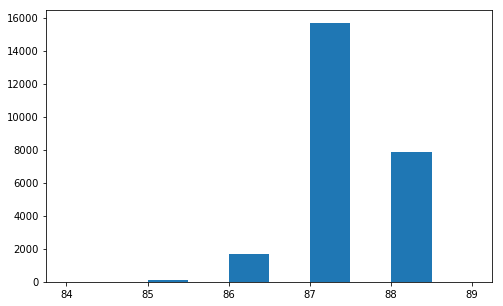

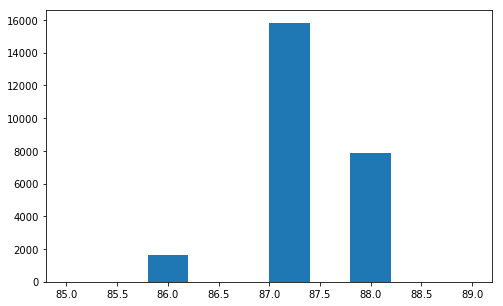

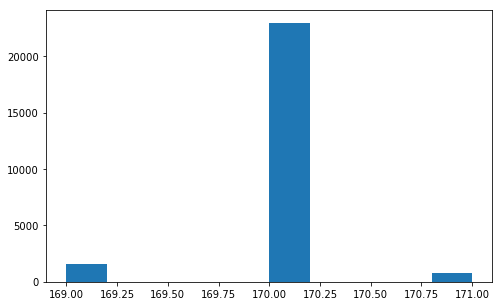

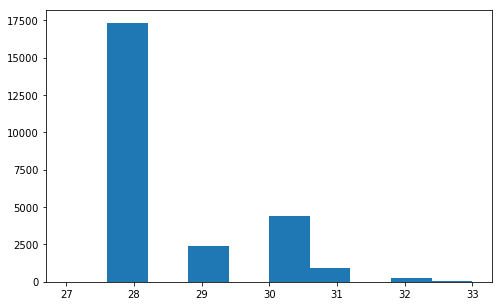

In [112]:
plt.close("all")
plt.figure(figsize=(8,5))
plt.hist(all_df.T_min1.values)
plt.show()

plt.figure(figsize=(8,5))
plt.hist(all_df.T_min2.values)
plt.show()

plt.figure(figsize=(8,5))
plt.hist(all_df.T_max.values)
plt.show()

plt.figure(figsize=(8,5))
plt.hist(all_df.dur_second.values)
plt.show()

# pack data

In [32]:
dir_temp = "./temperature_IGBT3_1/" 

Rth_df = pd.DataFrame()
for (_,_,files) in os.walk(dir_temp):
    for file in files:
        l = file[:-4].split("-")
        n_round = int(l[0])
        temp_df = pd.read_csv(dir_temp+file)
        Rth = temp_df.Rth_IGBT3_1.values[:100]
        df = pd.DataFrame(Rth.reshape(-1,1)).T
        df["round"] = n_round
        Rth_df = pd.concat([Rth_df,df],axis = 0)
        
Rth_df.to_csv("Rth_IGBT3_1.csv",index = False)

In [33]:
Rth_df.shape

(25353, 101)

In [34]:

Rth_df.head()     

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,round
0,0.030053,0.058441,0.076333,0.109352,0.113463,0.125407,0.129302,0.135867,0.136531,0.139866,...,0.169998,0.169557,0.170848,0.170421,0.170624,0.170149,0.171445,0.171009,0.171268,10000
0,0.028848,0.033312,0.059969,0.085074,0.112756,0.125582,0.129747,0.136494,0.137215,0.140731,...,0.171161,0.170717,0.172025,0.171577,0.171732,0.171280,0.172590,0.172232,0.172477,10001
0,0.030062,0.059109,0.086661,0.107568,0.122644,0.124312,0.130809,0.132950,0.137910,0.138480,...,0.168373,0.168594,0.168154,0.169426,0.168969,0.169207,0.169483,0.169093,0.170368,10002
0,0.028882,0.056361,0.084902,0.106717,0.123260,0.125127,0.132091,0.134463,0.139637,0.140352,...,0.170573,0.170709,0.170287,0.171592,0.171157,0.171358,0.170948,0.172257,0.171900,10003
0,0.030656,0.036863,0.065023,0.087242,0.113730,0.125289,0.129058,0.135499,0.136230,0.139621,...,0.168573,0.169868,0.169396,0.169596,0.169786,0.169307,0.170595,0.170202,0.170520,10004


In [35]:
Rth_df.sort_values(by = "round",inplace =True)
Rth_df.head() 

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,round
0,0.025927,0.051796,0.067042,0.099455,0.103149,0.114894,0.121274,0.123296,0.128393,0.128753,...,0.161442,0.161594,0.161121,0.162365,0.161938,0.162073,0.161626,0.162850,0.162387,5466
0,0.025435,0.029264,0.054272,0.076821,0.102332,0.110307,0.119722,0.120439,0.124643,0.127910,...,0.162174,0.161787,0.163034,0.162566,0.162766,0.162344,0.163588,0.163139,0.163313,5467
0,0.039877,0.053541,0.086794,0.094645,0.111242,0.115738,0.123246,0.123819,0.127424,0.128505,...,0.162728,0.164001,0.163598,0.163830,0.163419,0.164682,0.164300,0.164529,0.164769,5468
0,0.042901,0.070518,0.090822,0.110295,0.111591,0.118634,0.123250,0.124692,0.129030,0.129400,...,0.162550,0.162783,0.162332,0.163576,0.163152,0.163327,0.162942,0.164184,0.163741,5469
0,0.029962,0.059209,0.084448,0.107372,0.113423,0.121913,0.122564,0.126426,0.127668,0.131680,...,0.165256,0.164853,0.165061,0.164674,0.165950,0.165578,0.165815,0.165449,0.166711,5470


In [37]:
Rth_df = Rth_df.loc[Rth_df["round"].values <26989,:]
print(Rth_df.shape)
Rth_df.head() 

(21200, 101)


,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,round
0,0.025927,0.051796,0.067042,0.099455,0.103149,0.114894,0.121274,0.123296,0.128393,0.128753,...,0.161442,0.161594,0.161121,0.162365,0.161938,0.162073,0.161626,0.162850,0.162387,5466
0,0.025435,0.029264,0.054272,0.076821,0.102332,0.110307,0.119722,0.120439,0.124643,0.127910,...,0.162174,0.161787,0.163034,0.162566,0.162766,0.162344,0.163588,0.163139,0.163313,5467
0,0.039877,0.053541,0.086794,0.094645,0.111242,0.115738,0.123246,0.123819,0.127424,0.128505,...,0.162728,0.164001,0.163598,0.163830,0.163419,0.164682,0.164300,0.164529,0.164769,5468
0,0.042901,0.070518,0.090822,0.110295,0.111591,0.118634,0.123250,0.124692,0.129030,0.129400,...,0.162550,0.162783,0.162332,0.163576,0.163152,0.163327,0.162942,0.164184,0.163741,5469
0,0.029962,0.059209,0.084448,0.107372,0.113423,0.121913,0.122564,0.126426,0.127668,0.131680,...,0.165256,0.164853,0.165061,0.164674,0.165950,0.165578,0.165815,0.165449,0.166711,5470


In [38]:
Rth_df.to_csv("Rth_IGBT3_1_first.csv",index = False)

In [2]:
# import matplotlib.pyplot as plt
# # import numpy as np
import torch
from torch import nn


# Linear Regression Model
class linearRegression(nn.Module):
    def __init__(self):
        super(linearRegression, self).__init__()
        self.linear1 = nn.Linear(100, 10)  # input and output is 1 dimension
        self.relu1 = nn.ReLU(True)
        self.linear2 = nn.Linear(10, 1)  # input and output is 1 dimension
        self.relu2 = nn.ReLU(True)

    def forward(self, x):
        out = self.relu1(self.linear1(x))
        out = self.relu2(self.linear2(out))
        return out



ImportError: DLL load failed: 找不到指定的模块。

In [86]:
x_train = Rth_df.iloc[:,:100].values
y_train = Rth_df.loc[:,"round"].values/30000.0

x_train = torch.tensor(x_train,dtype = torch.float32 )
y_train = torch.tensor(y_train,dtype = torch.float32)
y_train.unsqueeze_(1)

tensor([[0.1822],
        [0.1822],
        [0.1823],
        ...,
        [0.8995],
        [0.8996],
        [0.8996]])

In [87]:
y_train.shape

torch.Size([21200, 1])

In [56]:
from torch.utils.data import Dataset
# step1: 定义MyDataset类， 继承Dataset, 重写抽象方法：__len()__, __getitem()__
class MyDataset(Dataset):
    def __init__(self, x_train, y_train, transform=None):
        self.x_train = x_train
        self.y_train = y_train
        self.transform = transform
        self.size = x_train.shape[0]

    def __len__(self):
        return self.size

    def __getitem__(self, idx):
        traindata = self.x_train[idx]   # use skitimage
        label = self.y_train[idx]

        sample = {'traindata': traindata, 'label': label}
        if self.transform:
            sample = self.transform(sample)

        return sample

In [88]:
myset = MyDataset(x_train,y_train)

In [89]:
from torch.utils.data import DataLoader
train_loader = DataLoader(myset, batch_size=256, shuffle=True)

In [75]:
for i,data in enumerate(train_loader):
    (X_batch, y_batch) = data["traindata"],data['label']
    print(type(X_batch))
    print(X_batch)
    break

<class 'torch.Tensor'>
tensor([[0.0458, 0.0620, 0.0969,  ..., 0.1700, 0.1703, 0.1699],
        [0.0215, 0.0473, 0.0743,  ..., 0.1581, 0.1594, 0.1590],
        [0.0223, 0.0467, 0.0742,  ..., 0.1579, 0.1592, 0.1588],
        ...,
        [0.0313, 0.0601, 0.0876,  ..., 0.1640, 0.1652, 0.1647],
        [0.0385, 0.0682, 0.0883,  ..., 0.1615, 0.1612, 0.1614],
        [0.0417, 0.0702, 0.0917,  ..., 0.1609, 0.1604, 0.1606]])


In [94]:
use_gpu = torch.cuda.is_available()
print("use gpu:",use_gpu)
model = linearRegression()
try:
    model.load_state_dict(torch.load('./model/linear.pth'))
except:
    pass
if use_gpu:
    model = model.cuda()

# 定义loss和优化函数
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# 开始训练
num_epochs = 100
model.train()
for epoch in range(num_epochs):
    for i,data in enumerate(train_loader):
        (X_batch, y_batch) = data["traindata"],data['label']
        if use_gpu:
            X_batch =X_batch.cuda()      
            y_batch =y_batch.cuda()
        out = model(X_batch)
        loss = criterion(out, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if (i+1) % 80 == 0:
            print(f'step:[{i+1}], loss: {loss.item():.6f}')
    


# model.eval()
# with torch.no_grad():
#     predict = model(x_train)
# predict = predict.data.numpy()

# fig = plt.figure(figsize=(10, 5))
# plt.plot(x_train.numpy(), y_train.numpy(), 'ro', label='Original data')
# plt.plot(x_train.numpy(), predict, label='Fitting Line')
# # 显示图例
# plt.legend() 
# plt.show()

# 保存模型
torch.save(model.state_dict(), './model/linear2.pth')



use gpu: True
step:[80], loss: 0.006165
step:[80], loss: 0.006017
step:[80], loss: 0.005889
step:[80], loss: 0.005901
step:[80], loss: 0.005489
step:[80], loss: 0.005704
step:[80], loss: 0.005633
step:[80], loss: 0.006027
step:[80], loss: 0.004964
step:[80], loss: 0.005459
step:[80], loss: 0.005316
step:[80], loss: 0.007048
step:[80], loss: 0.006044
step:[80], loss: 0.004551
step:[80], loss: 0.006660
step:[80], loss: 0.004784
step:[80], loss: 0.005598
step:[80], loss: 0.006192
step:[80], loss: 0.005618
step:[80], loss: 0.005588
step:[80], loss: 0.005113
step:[80], loss: 0.006291
step:[80], loss: 0.005133
step:[80], loss: 0.006771
step:[80], loss: 0.005337
step:[80], loss: 0.005207
step:[80], loss: 0.005296
step:[80], loss: 0.005040
step:[80], loss: 0.006757
step:[80], loss: 0.005486
step:[80], loss: 0.005574
step:[80], loss: 0.006826
step:[80], loss: 0.006284
step:[80], loss: 0.005196
step:[80], loss: 0.006067
step:[80], loss: 0.006559
step:[80], loss: 0.005297
step:[80], loss: 0.00595

In [96]:
model.eval()
with torch.no_grad():
    x_train = x_train.cuda()
    predict = model(x_train)
predict = predict.data.cpu.numpy()

AttributeError: 'builtin_function_or_method' object has no attribute 'numpy'

In [99]:
predict = predict.cpu



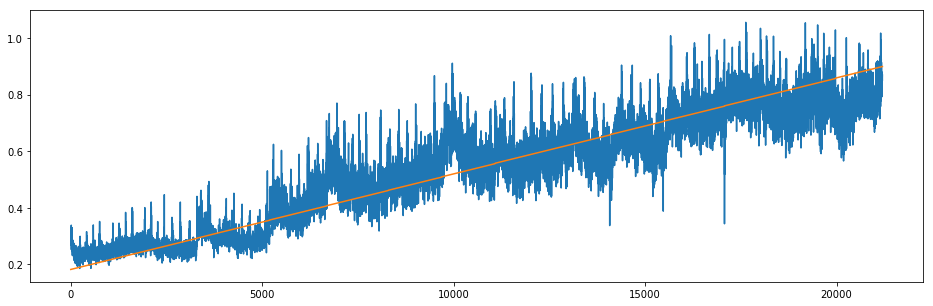

In [103]:
plt.close("all")
plt.figure(figsize=(16,5))
plt.plot(predict)
plt.plot(y_train)
plt.show()